In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
import pandas as pd
import json

from torch.autograd import Variable
from PIL import Image
from natsort import natsorted
from torch import optim
import torchvision

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
## change directory to get the data
os.chdir('/content/drive/MyDrive/Image-Caption')
os.getcwd()

'/content/drive/MyDrive/Image-Caption'

In [5]:
!unzip coco.zip

Streaming output truncated to the last 5000 lines.
  inflating: coco/images/000000008204.jpg  
  inflating: coco/images/000000008218.jpg  
  inflating: coco/images/000000008223.jpg  
  inflating: coco/images/000000008228.jpg  
  inflating: coco/images/000000008234.jpg  
  inflating: coco/images/000000008238.jpg  
  inflating: coco/images/000000008245.jpg  
  inflating: coco/images/000000008267.jpg  
  inflating: coco/images/000000008284.jpg  
  inflating: coco/images/000000008285.jpg  
  inflating: coco/images/000000008290.jpg  
  inflating: coco/images/000000008292.jpg  
  inflating: coco/images/000000008294.jpg  
  inflating: coco/images/000000008297.jpg  
  inflating: coco/images/000000008300.jpg  
  inflating: coco/images/000000008305.jpg  
  inflating: coco/images/000000008309.jpg  
  inflating: coco/images/000000008311.jpg  
  inflating: coco/images/000000008314.jpg  
  inflating: coco/images/000000008320.jpg  
  inflating: coco/images/000000008321.jpg  
  inflating: coco/images/

In [6]:
## number of images
len(os.listdir('./coco/images'))

5072

In [7]:
# check if .DS_Store is present
dataset_path = "./coco/images"

# Flag to indicate if .DS_Store is found
ds_store_found = False

# Recursively check for .DS_Store files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file == ".DS_Store":
            file_path = os.path.join(root, file)
            print(f".DS_Store found at: {file_path}")
            ds_store_found = True

if not ds_store_found:
    print("No .DS_Store file found in the path.")

.DS_Store found at: ./coco/images/.DS_Store


In [8]:
# Directory containing the dataset
dataset_path = "./coco/images"

# Recursively remove all .DS_Store files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file == ".DS_Store":
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"Removed: {file_path}")

Removed: ./coco/images/.DS_Store


In [9]:
len(os.listdir('./coco/images'))

5071

**Extracting Image Features**

In [10]:
## encoder CNN - using ResNet152

class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)

        # TO COMPLETE
        # keep all layers of the pretrained net except the last one
        self.model_11 = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, images):
        """Extract feature vectors from input images."""

        # TO COMPLETE
        # remember no gradients are needed
        self.model_11.eval()
        with torch.no_grad():
            features = self.model_11(images)
        features = features.view(features.size(0), -1)
        return features

In [11]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
encoder.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (model_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [12]:
## processing images

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [13]:
## images dataset class

class CoCoData(Dataset):
    def __init__(self, main_dir, transform):

        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform

        # List all images in folder and count them
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self,index):
        img_loc = os.path.join(self.main_dir, self.total_imgs[index])
        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        # Apply the transformations
        tensor_image = self.transform(image)
        return tensor_image

In [14]:
directory = "./coco/images"
image_names = []

for entry in os.scandir(directory):
    if(entry.is_file()):
        image_names.append(entry.name)

dataset = CoCoData(main_dir=directory, transform=data_transform)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

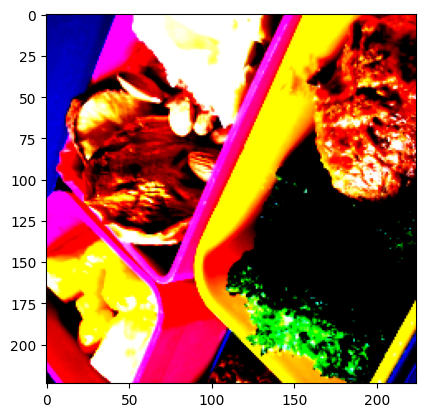

In [15]:
def timshow(x):
    xa = np.transpose(x)
    plt.imshow(xa)
    plt.show()

image = next(iter(train_loader))

timshow(torchvision.utils.make_grid(image))

In [16]:
## create encoded feature map of training images

feature_list = []
for data in train_loader:
    inputs = data.to(device)
    outputs = encoder(inputs)
    feature_list.append(outputs)
features = {}
for i in range(len(image_names)):
    features[image_names[i]] = feature_list[i]

In [17]:
## save the encoded images
torch.save(features, 'features_resnet152.pt')

**Text Preparation**

In [18]:
## build the caption dataset

with open('./coco/annotations2017/captions_train2017.json') as f:
    data = json.load(f)

df_captions=pd.DataFrame(data['annotations'])
df_captions=df_captions.sort_values(by=['image_id'])
df_captions.head()

image_id      id                                            caption
433247         9  661611  Closeup of bins of food that include broccoli ...
433499         9  667602         A bunch of trays that have different food.
433454         9  666765  Colorful dishes holding meat, vegetables, frui...
433325         9  663627  there are containers filled with different kin...
433263         9  661977  A meal is presented in brightly colored plasti...

In [19]:
df_coco = pd.read_csv('coco_subset_meta.csv', usecols = ['id', 'file_name'])
df_coco.rename(columns = {'id' : 'image_id'}, inplace = True)
df_coco=df_coco.sort_values(by=['image_id'])
df_coco.head()

file_name  image_id
5002  000000000009.jpg         9
4503  000000000009.jpg         9
4902  000000000009.jpg         9
2308  000000000025.jpg        25
5814  000000000030.jpg        30

In [20]:
merged_df = pd.merge(df_captions, df_coco, on='image_id', how='inner')
merged_df = merged_df.sort_values(by='image_id')
merged_df = merged_df.drop_duplicates()
merged_df.head()

image_id      id                                            caption  \
0          9  661611  Closeup of bins of food that include broccoli ...   
14         9  661977  A meal is presented in brightly colored plasti...   
11         9  663627  there are containers filled with different kin...   
8          9  666765  Colorful dishes holding meat, vegetables, frui...   
5          9  667602         A bunch of trays that have different food.   

           file_name  
0   000000000009.jpg  
14  000000000009.jpg  
11  000000000009.jpg  
8   000000000009.jpg  
5   000000000009.jpg

In [21]:
## clean the captions - a cleaned caption should be all lowercase, and consist of only alphabet characters.

merged_df['clean_caption']=merged_df['caption'].str.lower()
cap_list = []
for row in merged_df['clean_caption']:
    cap=""
    for ch in row:
        if(ch.isalpha() or ch == " "):
            cap+=ch
    cap_list.append(cap)
merged_df['clean_caption']=cap_list
merged_df=merged_df.sort_values(by=['image_id'])

In [22]:
captions_df = merged_df[['caption', 'clean_caption']]
captions_df.head(10)

caption  \
0   Closeup of bins of food that include broccoli ...   
14  A meal is presented in brightly colored plasti...   
11  there are containers filled with different kin...   
8   Colorful dishes holding meat, vegetables, frui...   
5          A bunch of trays that have different food.   
18  A giraffe standing next to a forest filled wit...   
17       Two giraffes standing in a tree filled area.   
19    A giraffe eating food from the top of the tree.   
15               A giraffe standing up nearby a tree    
16      A giraffe mother with its baby in the forest.   

                                        clean_caption  
0   closeup of bins of food that include broccoli ...  
14  a meal is presented in brightly colored plasti...  
11  there are containers filled with different kin...  
8   colorful dishes holding meat vegetables fruit ...  
5           a bunch of trays that have different food  
18  a giraffe standing next to a forest filled wit...  
17        two giraffes standing in a tree filled area  
19     a giraffe eating food from the top of the tree  
15               a giraffe standing up nearby a tree   
16       a giraffe mother with its baby in the forest

In [23]:
## split the data into train, test and validation sets

import random
import math

def split_ids(image_id_list, train=0.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)

    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [24]:
random.seed(0)

image_id_list=merged_df['image_id'].unique()
split_data = split_ids(image_id_list)

train_ids = split_data[0]
val_ids = split_data[1]
test_ids = split_data[2]

print(len(train_ids), len(val_ids), len(test_ids))

train_df = merged_df[merged_df['image_id'].isin(train_ids)]
val_df =  merged_df[merged_df['image_id'].isin(val_ids)]
test_df =  merged_df[merged_df['image_id'].isin(test_ids)]

3520 502 1007


In [25]:
l=[]
for i in train_ids:
    l.append(i)
for j in val_ids:
    l.append(j)

train_val = merged_df[merged_df['image_id'].isin(l)]

In [26]:
## building the vocabulary

class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Collect all words from the cleaned captions in the training and validation sets, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the Vocabulary() object and add all your words to it.

In [27]:
captions=train_val['clean_caption'].tolist()
res = []
for c in captions:
    arr = c.split()
    for a in arr:
        res.append(a)
counts = dict(Counter(res))
duplicates = {key:value for key, value in counts.items() if value > 3}

In [28]:
print(len(duplicates))

2400


In [29]:
vocab = Vocabulary()
for k in duplicates:
    vocab.add_word(k)

In [30]:
len(vocab)

2403

In [31]:
## create the dataset and dataloaders

class COCO_Subset(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """

    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper

        """

        # TO COMPLETE
        self.df = df
        self.features = features
        self.vocab = vocab


    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """

       # TO COMPLETE

        image_features = self.features[self.df['file_name'].iloc[index]]
        #print(image_features.shape)
        caption = self.df['clean_caption'].iloc[index]
        cap_words = caption.split()
        cap_tokens = []
        cap_pad = []
        for i in cap_words:
            cap_tokens.append(self.vocab(i))
        len_pad = 47 - len(cap_tokens)
        #cap_pad = cap_tokens
        for i in cap_tokens:
            cap_pad.append(i)
        cap_pad.append(self.vocab('<end>'))
        for i in range(len_pad-1):
            cap_pad.append(self.vocab('<pad>'))
        ten_cap_pad = torch.tensor(cap_pad)
        #print(ten_cap_pad.shape)
        cap_tokens.append(self.vocab('<end>'))
        len_cap = len(cap_tokens)
        ten_cap = torch.tensor(len_cap)
        return (image_features.squeeze(), ten_cap_pad, ten_cap)


    def __len__(self):
        return len(self.df)


In [32]:
features = torch.load('features_resnet152.pt')

dataset = COCO_Subset(train_df, features, vocab)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

val_dataset = COCO_Subset(val_df, features, vocab)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

<ipython-input-32-d260344b12a5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load('features_resnet152.pt')


In [33]:
train_iter = iter(train_loader)
feature, captions, lengths = next(train_iter)
print(feature.shape)
print(captions.shape)
print(lengths.shape)

torch.Size([64, 2048])
torch.Size([64, 47])
torch.Size([64])


**Decoder RNN**

In [34]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)

        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # TO COMPLETE
        self.rnn = nn.RNN(embed_size, hidden_size , num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length


    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)

        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)

        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].

        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens.data) # hiddens[0]
        return outputs


    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [35]:
# instantiate decoder
decoder = DecoderRNN(len(vocab)).to(device)

In [36]:
for param in decoder.parameters():
    print(param.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([2403, 256])
torch.Size([512, 256])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512])
torch.Size([2403, 512])
torch.Size([2403])


In [37]:
## train the decoder

def stats(loader, decoder):
    running_loss = 0
    n = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            image_features, caption, length = data
            #image_features = image_features.squeeze(1)

            # Move data to the same device as the decoder
            image_features = image_features.to(device)
            caption = caption.to(device)
            #length = length.to(device)

            outputs = decoder(image_features, caption, length)
            targets = pack_padded_sequence(caption, length, batch_first=True,enforce_sorted=False)[0]

            running_loss += loss_fn(outputs, targets)
            n += 1

    return running_loss/n

In [38]:
nepochs = 50
results_path = './results/epochs50hidden512adam.pt'
statsrec = np.zeros((2,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

decoder.train()

for epoch in range(nepochs):
    running_loss = 0.0
    n = 0
    for i, data in enumerate(train_loader):
        image_features, caption, length = data
        #image_features = image_features.squeeze(1)

        # Move data to the correct device
        image_features = image_features.to(device)
        caption = caption.to(device)
        #length = length.to(device)

        targets = pack_padded_sequence(caption, length, batch_first=True,enforce_sorted=False)[0]

        optimizer.zero_grad()

        outputs = decoder(image_features, caption, length)

        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n += 1

    ltrn = running_loss/n
    ltst = stats(val_loader, decoder)

    # Convert tensors to CPU and extract values for NumPy
    statsrec[:, epoch] = (ltrn, ltst.cpu().item() if isinstance(ltst, torch.Tensor) else ltst)
    #statsrec[:,epoch] = (ltrn, ltst)

# save network parameters and losses
torch.save({"state_dict": decoder.state_dict(), "stats": statsrec}, results_path)

<ipython-input-39-fcdaab725da9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(results_path)


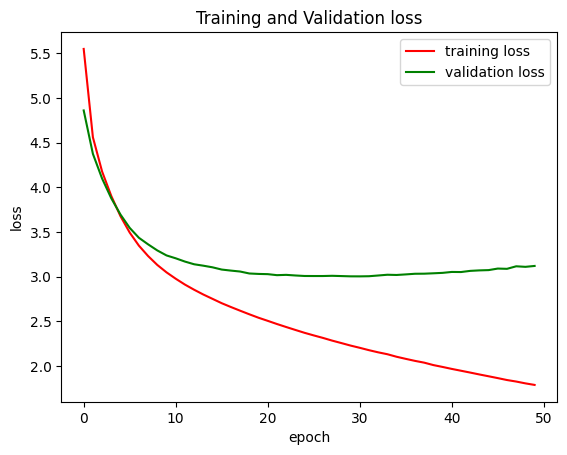

In [39]:
data = torch.load(results_path)
statsrec = data["stats"]

plt.plot(statsrec[0], 'r', label = 'training loss')
plt.plot(statsrec[1], 'g', label = 'validation loss' )
plt.legend(loc='upper right')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.show()

As seen from the graph above, the model starts overfitting around the 20th epoch. So ideally, that should be our stopping point.

In [49]:
decoder = DecoderRNN(len(vocab)).to(device)

nepochs = 25
results_path = './results/epochs25hidden512adam.pt'
statsrec = np.zeros((2,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

decoder.train()

for epoch in range(nepochs):
    running_loss = 0.0
    n = 0
    for i, data in enumerate(train_loader):
        image_features, caption, length = data
        #image_features = image_features.squeeze(1)

        # Move data to the correct device
        image_features = image_features.to(device)
        caption = caption.to(device)
        #length = length.to(device)

        targets = pack_padded_sequence(caption, length, batch_first=True,enforce_sorted=False)[0]

        optimizer.zero_grad()

        outputs = decoder(image_features, caption, length)

        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n += 1

    ltrn = running_loss/n
    ltst = stats(val_loader, decoder)

    # Convert tensors to CPU and extract values for NumPy
    statsrec[:, epoch] = (ltrn, ltst.cpu().item() if isinstance(ltst, torch.Tensor) else ltst)
    #statsrec[:,epoch] = (ltrn, ltst)
    print(f"epoch: {epoch+1} training loss: {ltrn: .3f} validation loss: {ltst: .3f} ")

# save network parameters and losses
torch.save({"state_dict": decoder.state_dict(), "stats": statsrec}, results_path)

epoch: 1 training loss:  5.556 validation loss:  4.822 
epoch: 2 training loss:  4.536 validation loss:  4.345 
epoch: 3 training loss:  4.148 validation loss:  4.059 
epoch: 4 training loss:  3.867 validation loss:  3.834 
epoch: 5 training loss:  3.634 validation loss:  3.644 
epoch: 6 training loss:  3.451 validation loss:  3.509 
epoch: 7 training loss:  3.318 validation loss:  3.421 
epoch: 8 training loss:  3.214 validation loss:  3.357 
epoch: 9 training loss:  3.125 validation loss:  3.288 
epoch: 10 training loss:  3.045 validation loss:  3.246 
epoch: 11 training loss:  2.975 validation loss:  3.208 
epoch: 12 training loss:  2.910 validation loss:  3.170 
epoch: 13 training loss:  2.851 validation loss:  3.148 
epoch: 14 training loss:  2.799 validation loss:  3.118 
epoch: 15 training loss:  2.749 validation loss:  3.103 
epoch: 16 training loss:  2.705 validation loss:  3.081 
epoch: 17 training loss:  2.658 validation loss:  3.071 
epoch: 18 training loss:  2.615 validati

In [50]:
# save network parameters and losses
results_path = './results/epochs25hidden512adam.pt'
torch.save({"state_dict": decoder.state_dict(), "stats": statsrec}, results_path)

<ipython-input-51-874707b0a068>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(results_path)


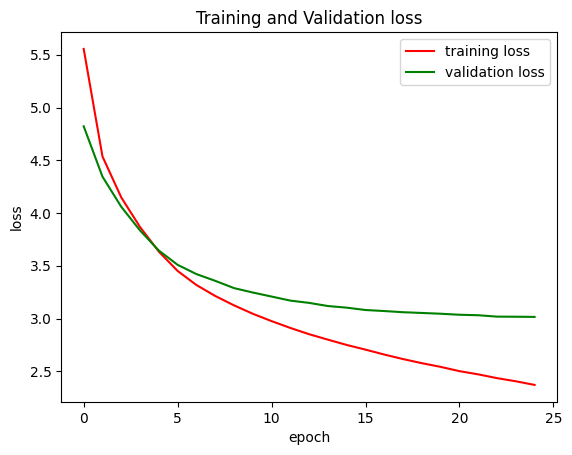

In [51]:
results_path = './results/epochs25hidden512adam.pt'
data = torch.load(results_path)
statsrec = data["stats"]

plt.plot(statsrec[0], 'r', label = 'training loss')
plt.plot(statsrec[1], 'g', label = 'validation loss' )
plt.legend(loc='upper right')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.show()

**Generate predictions on test data**

In [52]:
features = torch.load('features_resnet152.pt')
test_filename_unique = test_df['file_name'].unique()
#random.Random(5).shuffle(test_filename_unique)
image_5 = test_filename_unique[0:5]
f=[]
for item in features:
    if(item in image_5):
        f.append(features[item])

ft=torch.cat(f)

<ipython-input-52-6fac35535a34>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load('features_resnet152.pt')


In [53]:
#decoder = decoder.to(device)
decoder.eval()
gen_cap = []
with torch.no_grad():
    cap_dec = decoder.sample(ft)
for _, cap_data in enumerate(cap_dec):
    word_list = []
    for word in cap_data:
        word_list.append(vocab.idx2word[word.item()])
    end = word_list.index('<end>')
    word_list = word_list[0:end]
    gen_cap.append(word_list)
gen_cap = [" ".join(i) for i in gen_cap]
gen_cap

['a plate of food with broccoli and a bowl of soup',
 'two giraffes are standing in a field',
 'a vase of flowers in a vase on a table',
 'a train is parked on the tracks',
 'a woman riding a bike on a motorcycle']

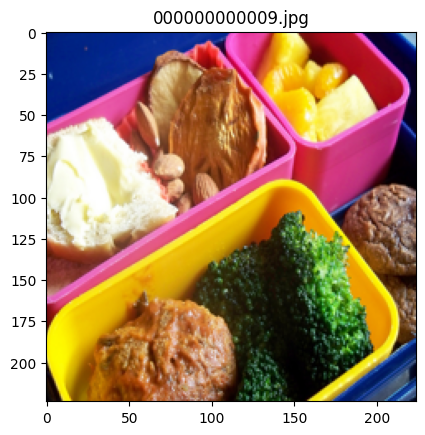

Reference Captions:
closeup of bins of food that include broccoli and bread
a meal is presented in brightly colored plastic trays
there are containers filled with different kinds of foods
colorful dishes holding meat vegetables fruit and bread
a bunch of trays that have different food


Generated Caption:
a plate of food with broccoli and a bowl of soup


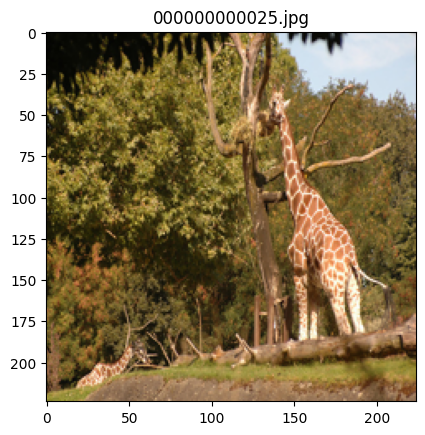

Reference Captions:
a giraffe standing next to a forest filled with trees
two giraffes standing in a tree filled area
a giraffe eating food from the top of the tree
a giraffe standing up nearby a tree 
a giraffe mother with its baby in the forest


Generated Caption:
two giraffes are standing in a field


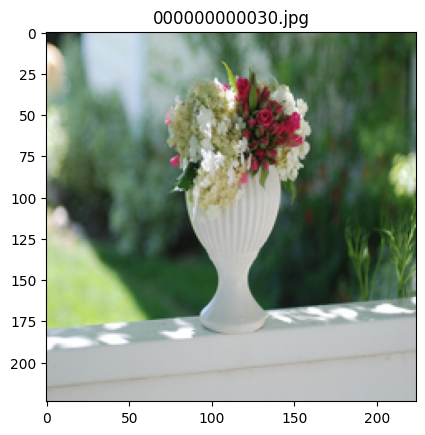

Reference Captions:
white vase with different colored flowers sitting inside of it 
a flower vase is sitting on a porch stand
a white vase filled with different colored flowers
a vase with red and white flowers outside on a sunny day
a white vase with many flowers on a stage


Generated Caption:
a vase of flowers in a vase on a table


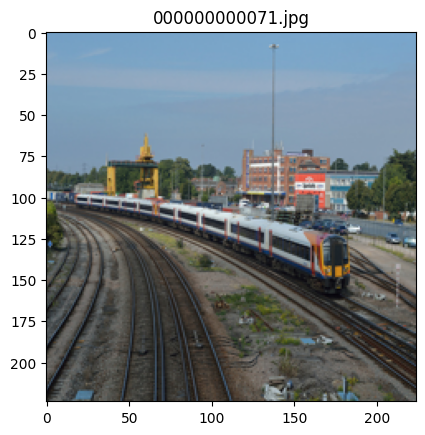

Reference Captions:
a train coming to a stop on the tracks out side
a passenger train glides around a curve on the outer track
the very long train is travelling down the tracks
a train engine carrying many carts down a track
a train coming down the tracks in the city


Generated Caption:
a train is parked on the tracks


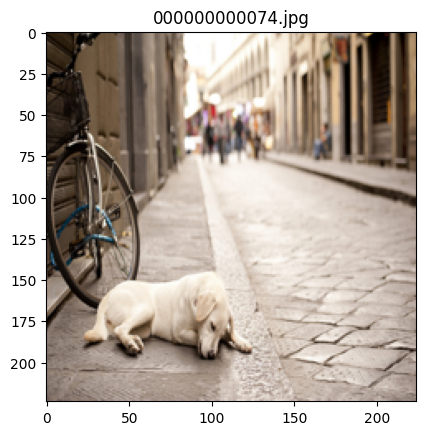

Reference Captions:
dog snoozing by a bike on the edge of a cobblestone street
the white dog lays next to the bicycle on the sidewalk
a white dog is sleeping on a street and a bicycle
a puppy rests on the street next to a bicycle
a picture of a dog laying on the ground


Generated Caption:
a woman riding a bike on a motorcycle


In [54]:
for i in range(len(image_5)):
    #fig = plt.figure(figsize=(8,8))
    im = Image.open('./coco/images/'+image_5[i])
    im = im.resize([224, 224])
    captions = list(merged_df['clean_caption'].loc[merged_df['file_name']== image_5[i]].values)
    #fig.add_subplot(i+1,2,1)
    plt.imshow(np.squeeze(im))
    plt.title(image_5[i])

    plt.show()
    print("Reference Captions:")
    for c in captions:
        print(c)
    print("\n")
    print ("Generated Caption:")
    print(gen_cap[i])

**Test the model on new images**

In [55]:
# Load the trained model
encoder = EncoderCNN()
decoder = DecoderRNN(len(vocab))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder.to(device)
decoder.to(device)

# Load the saved model parameters
checkpoint = torch.load('./results/epochs25hidden512adam.pt', map_location=device)
decoder.load_state_dict(checkpoint["state_dict"])
decoder.eval()

# Define transformations for the input image
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-55-1907bde00e7e>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more det

In [56]:
# Function to generate a caption for a given image
def generate_caption(image_path, encoder, decoder, vocab):
    """
    Generate a caption for an image.
    Args:
        image_path (str): Path to the image file.
        encoder (EncoderCNN): Trained image encoder model.
        decoder (DecoderRNN): Trained caption decoder model.
        vocab (Vocabulary): Vocabulary object used for the dataset.
    Returns:
        str: Generated caption for the image.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = data_transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Extract features using the encoder
    with torch.no_grad():
        features = encoder(image)

    # Generate a caption using the decoder
    with torch.no_grad():
        sampled_ids = decoder.sample(features)

    # Convert word IDs to words
    sampled_ids = sampled_ids[0].cpu().numpy()  # Get first sample (batch_size=1)
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        if word == '<end>':
            break
        if word != '<pad>':
            sampled_caption.append(word)

    return ' '.join(sampled_caption)

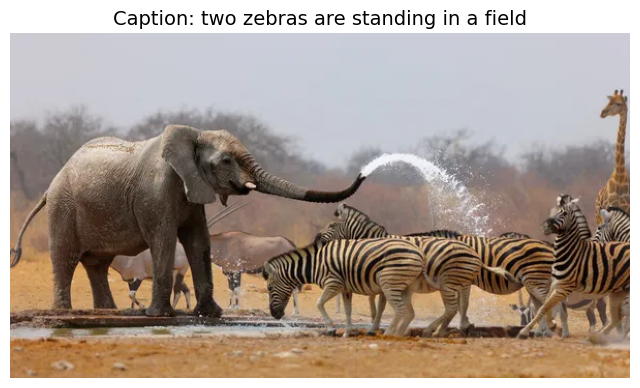

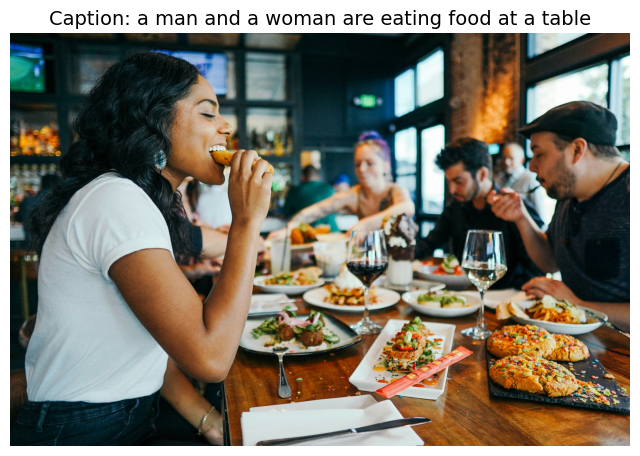

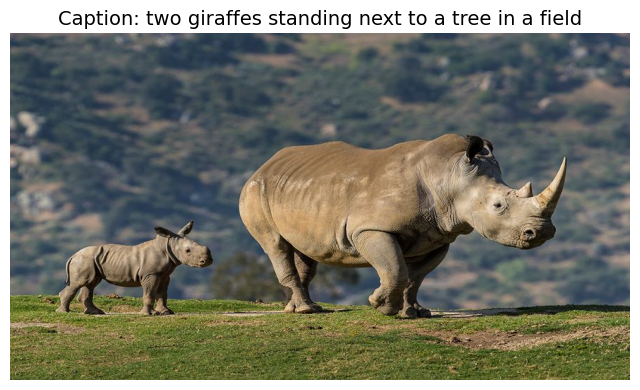

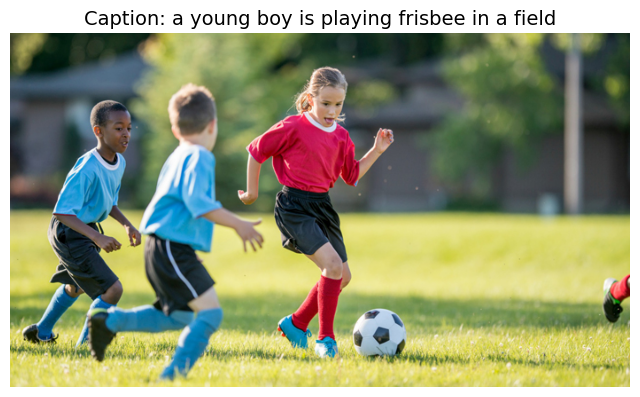

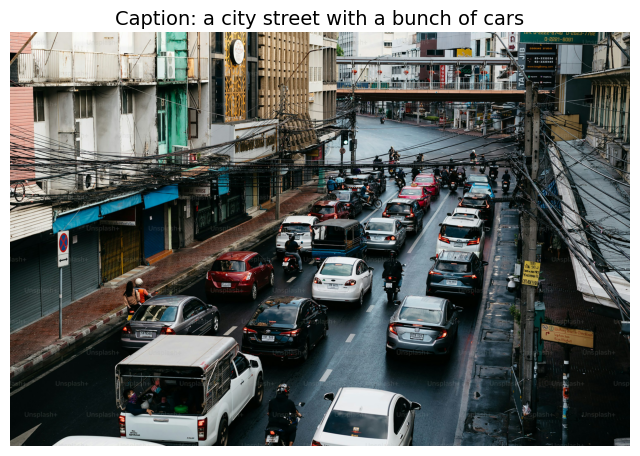

In [57]:
# Function to generate captions for all images in a folder
def generate_captions_for_folder(folder_path, encoder, decoder, vocab):
    """
    Generate captions for all images in a specified folder.
    Args:
        folder_path (str): Path to the folder containing images.
        encoder (EncoderCNN): Trained image encoder model.
        decoder (DecoderRNN): Trained caption decoder model.
        vocab (Vocabulary): Vocabulary object used for the dataset.
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    image_files.sort()  # Optional: sort the images alphabetically

    captions = []
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        caption = generate_caption(image_path, encoder, decoder, vocab)
        captions.append((image_path, caption))

    # Display images with captions
    for image_path, caption in captions:
        image = Image.open(image_path).convert("RGB")
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Caption: {caption}", fontsize=14, wrap=True)
        plt.show()

# Example usage
folder_path = "./test_images"  # Path to the folder containing images
generate_captions_for_folder(folder_path, encoder, decoder, vocab)

In [ ]:
## test metrics

In [ ]:
# TO COMPLETE

features = torch.load('features_resnet152.pt')
test_filename_unique = test_df['file_name'].unique()
f=[]
for item in features:
    if(item in test_filename_unique):
        f.append(features[item])
ft=torch.cat(f)
captions = []
for img in test_filename_unique:
    captions.append(list(test_df['clean_caption'].loc[test_df['file_name']== img].values))

b=[]
for i in captions:
    a=[]
    for j in i:
        a.append(j.split())
    b.append(a)

decoder.eval()
gen_cap = []
with torch.no_grad():
    cap_dec = decoder.sample(ft)
for _, cap_data in enumerate(cap_dec):
    word_list = []
    for word in cap_data:
        word_list.append(vocab.idx2word[word.item()])
    end = word_list.index('<end>')
    word_list = word_list[0:end]
    gen_cap.append(word_list)
pred_cap = [" ".join(i) for i in gen_cap]

<ipython-input-47-11cdf692b686>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load('features_resnet152.pt')


In [ ]:
pred_df = pd.DataFrame(list(zip(test_filename_unique,pred_cap)), columns=['file_name','predicted_captions'])
full_pred_df = pd.merge(test_df, pred_df, on='file_name', how='inner')

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

scores =[]
for i in range(len(test_filename_unique)):
    reference = b[i]
    candidate = gen_cap[i]
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
    scores.append(score)
score_df = pd.DataFrame(list(zip(test_filename_unique,scores)), columns=['file_name','bleu_score'])

full_bleu_df = pd.merge(full_pred_df, score_df, on='file_name', how='inner')
score_df.head()

file_name  bleu_score
0  000000000009.jpg    0.454545
1  000000000025.jpg    0.714286
2  000000000030.jpg    0.625000
3  000000000071.jpg    0.644123
4  000000000074.jpg    0.545455

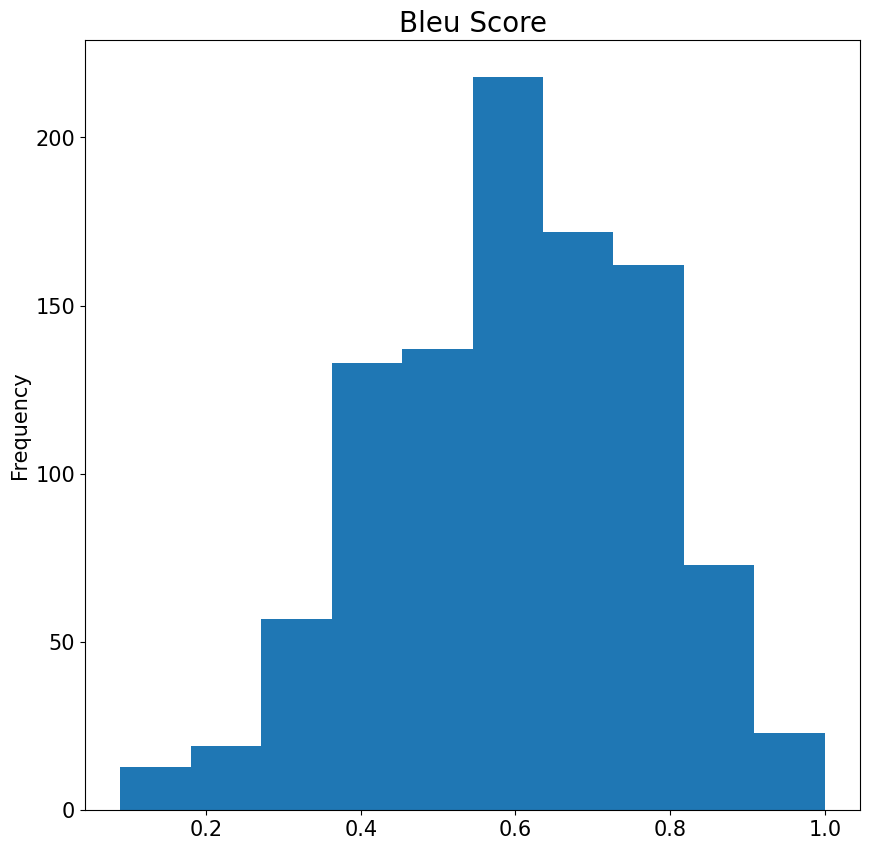

In [ ]:
plt.title("Bleu Score", fontsize = 20)
plt.xlabel("Range of Score",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
ax = score_df['bleu_score'].plot.hist(rot=0,figsize=(10,10),fontsize=15)
plt.show()

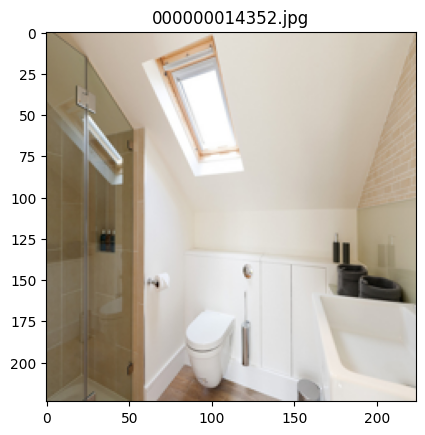

Reference Captions:
a new bathroom installed in an attic space
a toilet sink and shower in a bathroom with a skylight 
a bathroom is decorated in white and tan
a minimalistic bathroom with a sloping ceiling and skylight
a modern bathroom design with a skylight above the toilet


Generated Caption:
a bathroom with a toilet and a sink


Bleu Score:  1.0


In [ ]:
# TO COMPLETE
highest_score = score_df['bleu_score'].max()
pred_cap_highest_score = pred_cap[score_df['bleu_score'].idxmax()]
ref_cap_highest_score = captions[score_df['bleu_score'].idxmax()]

im = Image.open('./coco/images/'+score_df['file_name'][score_df['bleu_score'].idxmax()])
im = im.resize([224, 224])

plt.imshow(np.squeeze(im))
plt.title(score_df['file_name'][score_df['bleu_score'].idxmax()])

plt.show()

print("Reference Captions:")
for c in ref_cap_highest_score:
    print(c)
print("\n")
print ("Generated Caption:")
print(pred_cap_highest_score)
print("\n")
print("Bleu Score: ", highest_score)

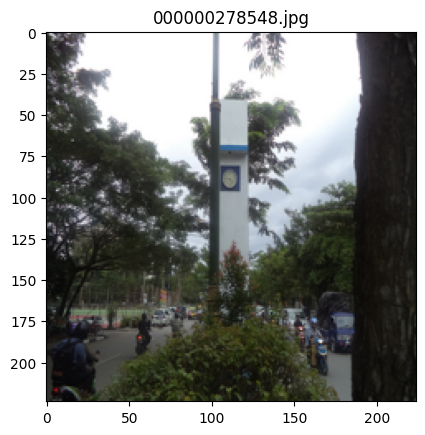

Reference Captions:
cars and motorcycles pass along either side of a clock tower
clock in a tall structure on the median between two directions of traffic
people riding scooters with the clock in the median stating time of pm
a busy street filled with lots of traffic and lots of trees
a number of motorcycles on a street near a baseball field 


Generated Caption:
a large white <unk> <unk> <unk> <unk> <unk> <unk>


Bleu Score:  0.08897082254631197


In [ ]:
lowest_score = score_df['bleu_score'].min()
pred_cap_lowest_score = pred_cap[score_df['bleu_score'].idxmin()]
ref_cap_lowest_score = captions[score_df['bleu_score'].idxmin()]

im = Image.open('./coco/images/'+score_df['file_name'][score_df['bleu_score'].idxmin()])
im = im.resize([224, 224])

plt.imshow(np.squeeze(im))
plt.title(score_df['file_name'][score_df['bleu_score'].idxmin()])

plt.show()

print("Reference Captions:")
for c in ref_cap_lowest_score:
    print(c)
print("\n")
print ("Generated Caption:")
print(pred_cap_lowest_score)
print("\n")
print("Bleu Score: ", lowest_score)

In [ ]:
## cosine similarity

In [ ]:
features = torch.load('features_resnet152.pt')
test_dataset = COCO_Subset(test_df, features, vocab)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    num_workers=0
)

test_features, test_captions, test_lengths = next(iter(test_loader))


decoder.eval()
gen_cap = []
with torch.no_grad():
    cap_dec = decoder.sample(test_features)
for _, cap_data in enumerate(cap_dec):
    word_list = []
    for word in cap_data:
        word_list.append(vocab.idx2word[word.item()])
    end = word_list.index('<end>')
    word_list = word_list[0:end]
    gen_cap.append(word_list)
predicted_cap = [" ".join(i) for i in gen_cap]

<ipython-input-53-d105f3fa8acc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load('features_resnet152.pt')


In [ ]:
# TO COMPLETE

# Move test_captions and cap_dec to the same device as the decoder
test_captions = test_captions.to(device)
cap_dec = cap_dec.to(device)

embed_reference = decoder.embed(test_captions)

embed_predicted = decoder.embed(cap_dec)

reference_mean_vector = []
for ref in embed_reference:
    reference_mean_vector.append(ref.mean(1))

predicted_mean_vector= []
for pred in embed_predicted:
    predicted_mean_vector.append(pred.mean(1))

cosine_score=[]
cosine = nn.CosineSimilarity(dim=0, eps=1e-9)
for i in range(len(reference_mean_vector)):
    output = (cosine(reference_mean_vector[i], predicted_mean_vector[i]))
    cosine_score.append(output)

cos_list = []
for score in cosine_score:
    cos_list.append(score.detach().cpu().numpy())

cosine_df = pd.DataFrame(list(zip(test_df['file_name'], cos_list)), columns=['file_name','cosine_score'])
cosine_df.head()

file_name cosine_score
0  000000000009.jpg  -0.18591392
1  000000000009.jpg   -0.1839932
2  000000000009.jpg  -0.12346849
3  000000000009.jpg  -0.46812648
4  000000000009.jpg   -0.2568186

In [ ]:
#average of cos similarity
print("The average score of cosine similarity:",cosine_df['cosine_score'].mean())

The average score of cosine similarity: -0.16961868686085185


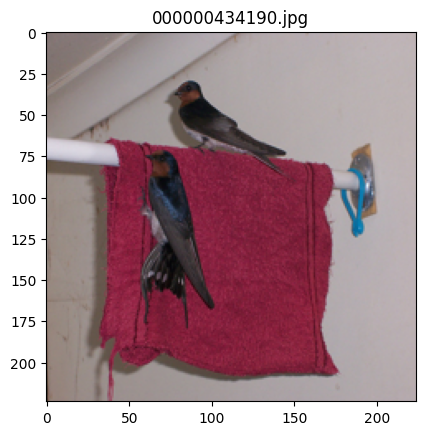

Reference Captions:
two birds sitting on a towel hanging in a restroom
two birds are on a towel in a bathroom shower rod
two birds sitting on a red towel on a shower pole
one bird sitting on a shower curtain rod next to another bird hanging on to a wash cloth draped over the same shower curtain rod
two birds perching on a red towel hung over a towel rack


Generated Caption:
a bird sitting on top of a black and white dog


Cosine Similarity:  0.19885874


In [ ]:
# TO COMPLETE
highest_score = cosine_df['cosine_score'].max()
idxmax = cosine_df['cosine_score'].idxmax()
pred_cap_highest_score = predicted_cap[idxmax]
pred_cap_highest_score = pred_cap_highest_score.replace(' <end>', '')

file_name = cosine_df['file_name'][idxmax]

ref_cap_highest_score = list(test_df[test_df['file_name']==file_name]['clean_caption'])

im = Image.open('./coco/images/'+file_name)
im = im.resize([224, 224])

plt.imshow(np.squeeze(im))
plt.title(file_name)

plt.show()

print("Reference Captions:")
for c in ref_cap_highest_score:
    print(c)
print("\n")
print ("Generated Caption:")
print(pred_cap_highest_score)
print("\n")
print("Cosine Similarity: ", highest_score)

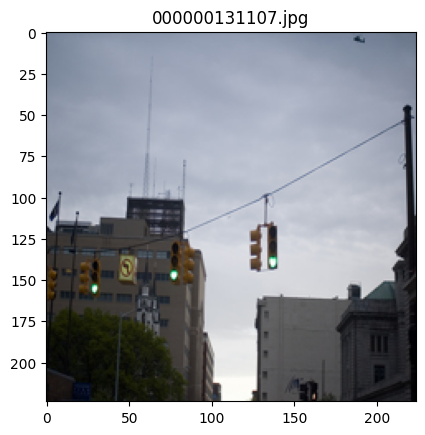

Reference Captions:
stop lights hanging from a wire showing green
three traffic signals on a cable with a no left turn signal
three green traffic lights some buildings and trees
three streetlights are hanging and showing green 
several traffic lights hanging on a line over a street


Generated Caption:
a street sign with a <unk> <unk> on a street


Cosine Similarity:  -0.48628435


In [ ]:
lowest_score = cosine_df['cosine_score'].min()
idxmin = cosine_df['cosine_score'].idxmin()
pred_cap_lowest_score = predicted_cap[idxmin]
pred_cap_lowest_score = pred_cap_lowest_score.replace(' <end>', '')

file_name = cosine_df['file_name'][idxmin]

ref_cap_lowest_score = list(test_df[test_df['file_name']==file_name]['clean_caption'])

im = Image.open('./coco/images/'+file_name)
im = im.resize([224, 224])

plt.imshow(np.squeeze(im))
plt.title(file_name)

plt.show()

print("Reference Captions:")
for c in ref_cap_lowest_score:
    print(c)
print("\n")
print ("Generated Caption:")
print(pred_cap_lowest_score)
print("\n")
print("Cosine Similarity: ", lowest_score)

Average Bleu Score: 0.5970386712339745
Average Cosine Similarity Score:  0.4151908870436165


Text(0, 0.5, 'Frequency')

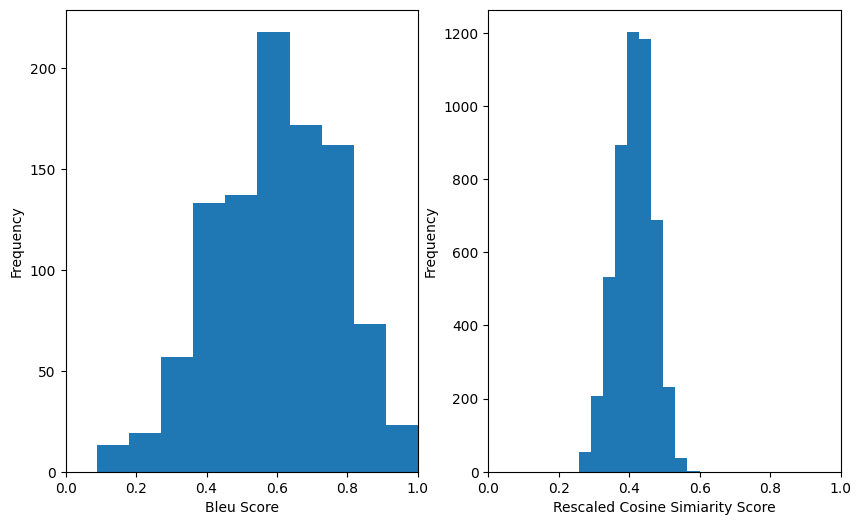

In [ ]:
# TO COMPLETE
cos_list_rescaled = []
for cos in cos_list:
    cos_list_rescaled.append(cos/2+0.5)
rescaled_cosine_df = pd.DataFrame(list(zip(test_df['file_name'], cos_list_rescaled)),
                                  columns=['file_name','rescaled_cosine_score'])

print("Average Bleu Score:", score_df['bleu_score'].mean())
print("Average Cosine Similarity Score: ", rescaled_cosine_df['rescaled_cosine_score'].mean())


fig = plt.figure(figsize=[10,10])
sub1 = plt.subplot(1,2,1)
score_df['bleu_score'].plot.hist(figsize=(10,6))
sub1.set_xbound(0,1)
plt.xlabel("Bleu Score")
plt.ylabel("Frequency")

sub2=plt.subplot(1,2,2)
rescaled_cosine_df['rescaled_cosine_score'].plot.hist(figsize=(10,6))
sub2.set_xbound(0,1)
plt.xlabel("Rescaled Cosine Simiarity Score")
plt.ylabel("Frequency")

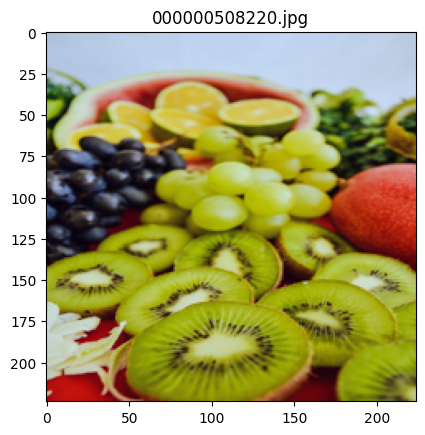

Reference Captions:
an assortment of fruits stacked on top of each other
a plate topped with lots of different fruits
kiwis cut in half with green grapes red grapes and other fruit
a variety of different fruits with kiwi slices displayed prominently 
a spread of fruit including red and green grapes kiwis and oranges


Generated Caption:
a bunch of bananas and vegetables on a table


Bleu Score:  0.4444444444444444
Cosine Similarity:  0.4444495923817158


In [ ]:
# TO COMPLETE
diff_df=pd.DataFrame(full_bleu_df['bleu_score'].subtract(rescaled_cosine_df['rescaled_cosine_score']).abs(), columns=['score_diff'])

similar_idx = diff_df['score_diff'].idxmin()
similar_cosine_score = rescaled_cosine_df['rescaled_cosine_score'][similar_idx]
similar_bleu_score = full_bleu_df['bleu_score'][similar_idx]

similar_pred_cap = full_bleu_df['predicted_captions'][similar_idx]
file_name = full_bleu_df['file_name'][similar_idx]

similar_ref_cap = list(test_df[test_df['file_name']==file_name]['clean_caption'])

im = Image.open('./coco/images/'+file_name)
im = im.resize([224, 224])

plt.imshow(np.squeeze(im))
plt.title(file_name)

plt.show()

print("Reference Captions:")
for c in similar_ref_cap:
    print(c)
print("\n")
print ("Generated Caption:")
print(similar_pred_cap)
print("\n")
print("Bleu Score: ", similar_bleu_score)
print("Cosine Similarity: ", similar_cosine_score)